In [2]:
import numpy as np
import rescomp

import matplotlib.pyplot as plt
import pyfftw

In [1]:
import sys
sys.executable

'C:\\Users\\Dennis\\anaconda3\\envs\\rc_env_KS_1\\python.exe'

### KS System:

In [ ]:
# KS system:
dimensions = 40
system_size = 30
def data_creation_function_KS(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulate_trajectory(
            sys_flag='kuramoto_sivashinsky', dimensions=dimensions, system_size=system_size, dt=dt,
            time_steps=time_steps, starting_point = starting_point)
    return sim_data

def data_creation_function_KS_Bhatt(time_steps, dt, starting_point=None):
    sim_data = rescomp.simulations._kuramoto_sivashinsky_Bhatt(dimensions=dimensions, system_size=system_size, dt=dt,
                                                    time_steps=time_steps, starting_point=starting_point,
                                                    alpha=1, beta=1)
    return sim_data

In [ ]:
dt = 0.1
N = 100
tau = 5
T = 2
eps = 1e-6
m = 12

In [ ]:
same_starting_point = data_creation_function_KS(time_steps=1, dt=1, starting_point=None)[-1]

f1 = lambda x: data_creation_function_KS(time_steps=2, dt=dt, starting_point=x)[-1]
f2 = lambda x: data_creation_function_KS_Bhatt(time_steps=2, dt=dt, starting_point=x)[-1]

In [ ]:
# original KS Sim:
lyapunov_exp, lyapunov_exp_convergence = rescomp.measures.iterator_based_lyapunov_spectrum(f1, 
                                                                                           starting_point=same_starting_point, 
                                                                                           T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
# Bhatt KS Sim:
lyapunov_exp_B, lyapunov_exp_convergence_B = rescomp.measures.iterator_based_lyapunov_spectrum(f2, 
                                                                                               starting_point=same_starting_point,
                                                                                               T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True, nr_of_lyapunovs=m)

In [ ]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
print(lyapunov_exp_B)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence_B.T:
    plt.plot(iteration[20:])
plt.grid()

In [ ]:
delta_exp = lyapunov_exp_B - lyapunov_exp
print(delta_exp)
plt.figure(figsize=(10,5))
for iteration in np.abs(lyapunov_exp_convergence_B - lyapunov_exp_convergence).T:
    plt.plot(iteration[20:])
plt.grid()

# Test _kuramoto_sivashinsky_custom

In [18]:
# Sweep:
precisions = [128, 64, 32, 16]
fft_types = ["numpy", "scipy", "pyfftw_np", "pyfftw_sc", "pyfftw_fftw"]

# Fixed:
starting_point=None
dimensions = 40
system_size = 30

# LE-Algo:
dt = 0.1
N = 100
tau = 10
T = 5
eps = 1e-6
m = 12

def create_ks_sim_func(fft_type, prec, dimensions, system_size):
    def data_creation_function(time_steps, dt, starting_point=None):
        return rescomp.simulations._kuramoto_sivashinsky_custom(dimensions, system_size, dt, time_steps, starting_point,
                                 precision=prec, fft_type=fft_type)
    return data_creation_function
                                                        
data_creation_functions_dict = {}
for prec in precisions:
    for fft_type in fft_types:
        data_creation_functions_dict[(prec, fft_type)] = create_ks_sim_func(fft_type, prec, dimensions, system_size)

In [19]:
res_dict = {}

i = 1
for key, func in data_creation_functions_dict.items():
    print(i, key)
    i+=1
    f = lambda x: func(time_steps=2, dt=dt, starting_point=x)[-1]
    try:
        lyapunov_exp_res = rescomp.measures.iterator_based_lyapunov_spectrum(f, 
                                                                             starting_point, 
                                                                             T=T, 
                                                                             tau=tau,
                                                                             eps=eps, 
                                                                             nr_steps=N, 
                                                                             dt=dt, 
                                                                             return_convergence=True,
                                                                             nr_of_lyapunovs=m)
        res_dict[key] = lyapunov_exp_res
    except Exception as e:
        print("Error: ", e)
        res_dict[key] = e
    

1 (128, 'numpy')
Error:  data type "float128" not understood
2 (128, 'scipy')
Error:  data type "float128" not understood
3 (128, 'pyfftw_np')
Error:  data type "float128" not understood
4 (128, 'pyfftw_sc')
Error:  module 'pyfftw.interfaces' has no attribute 'scipy_fft'
5 (128, 'pyfftw_fftw')
Error:  data type "float128" not understood
6 (64, 'numpy')
7 (64, 'scipy')
8 (64, 'pyfftw_np')
9 (64, 'pyfftw_sc')
Error:  module 'pyfftw.interfaces' has no attribute 'scipy_fft'
10 (64, 'pyfftw_fftw')
11 (32, 'numpy')
12 (32, 'scipy')
13 (32, 'pyfftw_np')
14 (32, 'pyfftw_sc')
Error:  module 'pyfftw.interfaces' has no attribute 'scipy_fft'
15 (32, 'pyfftw_fftw')


c:\users\dennis\documents\github\rescomp\rescomp\simulations.py:783: RuntimeWarning: invalid value encountered in multiply
  v = E * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3


16 (16, 'numpy')
Error:  data type "complex32" not understood
17 (16, 'scipy')
Error:  data type "complex32" not understood
18 (16, 'pyfftw_np')
Error:  data type "complex32" not understood
19 (16, 'pyfftw_sc')
Error:  module 'pyfftw.interfaces' has no attribute 'scipy_fft'
20 (16, 'pyfftw_fftw')
Error:  data type "complex32" not understood


(128, 'numpy'), error: data type "float128" not understood
(128, 'scipy'), error: data type "float128" not understood
(128, 'pyfftw_np'), error: data type "float128" not understood
(128, 'pyfftw_sc'), error: module 'pyfftw.interfaces' has no attribute 'scipy_fft'
(128, 'pyfftw_fftw'), error: data type "float128" not understood
(64, 'pyfftw_sc'), error: module 'pyfftw.interfaces' has no attribute 'scipy_fft'
(32, 'pyfftw_sc'), error: module 'pyfftw.interfaces' has no attribute 'scipy_fft'
(16, 'numpy'), error: data type "complex32" not understood
(16, 'scipy'), error: data type "complex32" not understood
(16, 'pyfftw_np'), error: data type "complex32" not understood
(16, 'pyfftw_sc'), error: module 'pyfftw.interfaces' has no attribute 'scipy_fft'
(16, 'pyfftw_fftw'), error: data type "complex32" not understood
others:


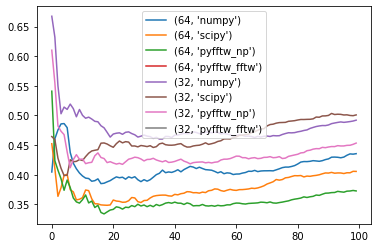

In [24]:
for key, val in res_dict.items():
    if type(val) == tuple:
        largest_le_index = np.argmax(val[0])
        largest_le_evol = val[1][:, largest_le_index]
        
        plt.plot(largest_le_evol, label=key)
    else:
        print(f"{key}, error: {val}")

print("others:")
plt.legend()

### Lorenz system:

In [ ]:
# Lorenz system
def data_creation_function_Lorenz(time_steps, dt, starting_point=None):
    return  rescomp.simulate_trajectory(
            sys_flag='lorenz', dt=dt, time_steps=time_steps,
            starting_point=starting_point)

In [ ]:
# Parameter ranges:
dts = [0.25, 0.1, 0.05, 0.01]
Ns = [100, 1000]
tau = 100
Ts = [0.1, 1, 10]
epss = [1e-8, 1e-6, 1e-3]
m = 3

starting_point = np.array([-14.03020521, -20.88693127, 25.53545])

lyapexp_array = np.zeros((len(dts), len(Ns), len(Ts), len(epss), m))

for i_dt, dt in enumerate(dts):
    print(f"dt: {dt}")
    def f(x):
        return data_creation_function_Lorenz(time_steps=2, dt=dt, starting_point=x)[-1]
    for i_N, N in enumerate(Ns):
        print(f"N: {N}")
        for i_T, T in enumerate(Ts):
            for i_eps, eps in enumerate(epss):
                lyapexp_array[i_dt, i_N, i_T, i_eps, :] = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point, T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=False, nr_of_lyapunovs = m)
                


In [ ]:
lyapexp_array.shape

In [ ]:
x_axis_ticks = []
for i_dt, dt in enumerate(dts):
    for i_N, N in enumerate(Ns):
        for i_T, T in enumerate(Ts):
            for i_eps, eps in enumerate(epss):
                x_axis_ticks.append(f"dt({dt}), N({N}), T({T}), eps({eps})")

In [ ]:
# data:
first = lyapexp_array[:, :, :, :, 0]
second = lyapexp_array[:, :, :, :, 1]
thrid = lyapexp_array[:, :, :, :, 2]

# plot:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,10), sharex=True)

ax = axs[0]
ax.grid()
ax.plot(x_axis_ticks, first.flatten())
ax.set_title("first lyapunov")

ax = axs[1]
ax.grid()
ax.plot(second.flatten())
ax.set_title("second lyapunov")

ax = axs[2]
ax.grid()
ax.plot(thrid.flatten())
ax.set_title("third lyapunov")

In [ ]:
x_axis_ticks = dts

colors_eps = {0: "r", 1: "b", 2: "g"}
linestyles_T = {0: "--", 1: "-", 2: "dotted"}

# plot:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(15,15), sharex=True)

ax = axs[0]
ax.grid()

for i_T, T in enumerate(Ts):
    for i_eps, eps in enumerate(epss):
        ax.plot(x_axis_ticks, lyapexp_array[:, -1, i_T, i_eps, 0], label=f"N: {N}, T= {T}, eps = {eps}",
                linestyle=linestyles_T[i_T], color=colors_eps[i_eps])
ax.set_title("first lyapunov")


ax = axs[1]
ax.grid()
for i_T, T in enumerate(Ts):
    for i_eps, eps in enumerate(epss):
        ax.plot(x_axis_ticks, lyapexp_array[:, -1, i_T, i_eps, 1], label=f"N: {N}, T= {T}, eps = {eps}",
                linestyle=linestyles_T[i_T], color=colors_eps[i_eps])
ax.set_title("second lyapunov")

ax = axs[2]
ax.grid()
for i_T, T in enumerate(Ts):
    for i_eps, eps in enumerate(epss):
        ax.plot(x_axis_ticks, lyapexp_array[:, -1, i_T, i_eps, 2], label=f"N: {N}, T= {T}, eps = {eps}",
                linestyle=linestyles_T[i_T], color=colors_eps[i_eps])
ax.set_title("third lyapunov")

ax.set_xticks(x_axis_ticks)
ax.set_xlabel("dt")

plt.legend(loc="best")

In [ ]:
best = lyapexp_array[-2, -1, 1, 0, :]
print(best)

In [ ]:
starting_point = np.array([-14.03020521, -20.88693127, 25.53545])

f = lambda x: data_creation_function_Lorenz(time_steps=2, dt=dt, starting_point=x)[-1]


lyapunov_exp, lyapunov_exp_convergence = rescomp.measures.iterator_based_lyapunov_spectrum(f, starting_point, T=T, 
                                                                                           tau=tau,
                                                  eps=eps, nr_steps=N, dt=dt, return_convergence=True)

In [ ]:
print(lyapunov_exp)
plt.figure(figsize=(10,5))
for iteration in lyapunov_exp_convergence.T:
    plt.plot(iteration)
plt.grid()

print(rescomp.measures.KY_dimension(lyapunov_exp))